This note book will look at the effect of enacting a seatbelt law affected the number of casualties (deaths and serious injuries) in the U.K. in the 80s. We have [the number of casualties in the U.K. road accidents each month, from Jan 1969 to Dec 1984](https://datamarket.com/data/set/22p5/number-of-deaths-and-serious-injuries-in-uk-road-accidents-each-month-jan-1969-dec-1984-seatbelt-law-introduced-in-feb-1983-indicator-in-second-column#!ds=22p5!2eks&display=line). I will start by using the typical $t$-test and moving on to an ARMA model to acount for changes in time. 

The following Libraries will be used:
 - MatplotLib will be used for plotting the data. 
 - SciPy will be used for statistical tests and defining probability distributions. 
 - NumPy will be used for numerical work.
 - Pandas will be used to conviniently manipulate the data. 
 - statsmodels contains most of the tools I will use to do time series analysis. 

In [147]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Loading the Data
First thing's first: we need to load the data. The csv contains 192 rows indexed by months from Jan 1969 to Dec 1984. There are two columns. One column is the number of casusalties for that month. The other column is simply an indicator variable with a 0 if the month was before the seatbelt law was enacted and a 1 otherwise.

There is also a row that is just notes about the data and need to be removed. 

In [148]:
# Laoding data from CSV
casualtyData = pd.read_csv("Data/number-of-deaths-and-serious-inj.csv")

# Giving columns more convinient names
casualtyData.columns = ["month", "casualties", "lawEnacted"]

# Remove last row since it only contains a note, not data.
casualtyData.drop(casualtyData.index[-1], inplace=True)

casualtyData.index = pd.to_datetime(casualtyData.month).values

casualtyData.drop("month", axis=1, inplace=True)

casualtyData.sample(10)

,casualties,lawEnacted
1975-12-01,2199.0,0.0
1969-03-01,1507.0,0.0
1973-12-01,2150.0,0.0
1981-10-01,1938.0,0.0
1974-04-01,1382.0,0.0
1976-08-01,1327.0,0.0
1983-01-01,1494.0,0.0
1975-02-01,1356.0,0.0
1983-05-01,1236.0,1.0
1983-04-01,1168.0,1.0


It will also be convinient to define `law_start` to store the date the law was enacted.

In [149]:
law_start = casualtyData[casualtyData.lawEnacted == 1].index[0]

Now let's plot the data over time. I will include a vertical yellow line to represent when the law was enacted.

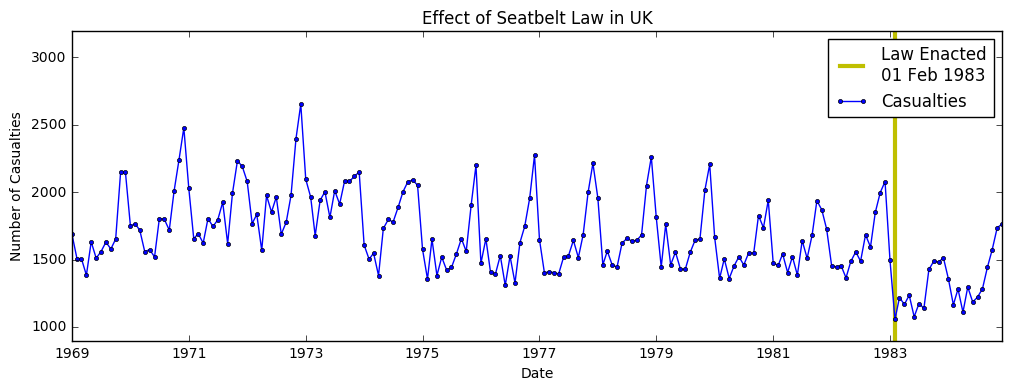

In [150]:
plt.figure(0, figsize=[12,4])
plt.axvline(law_start, c="y", lw=3, label="Law Enacted\n{}".format(law_start.strftime("%d %b %Y")))
plt.plot(casualtyData.casualties, "-ob", ms=3, lw=1, label="Casualties")
plt.ylim(900,3200)
plt.title("Effect of Seatbelt Law in UK")
plt.xlabel("Date")
plt.ylabel("Number of Casualties")
plt.legend(loc="lower left")
plt.legend()
plt.show()

## t-Test 
To run a $t$-test, we need to split the data into pre-law and post-law sets. 

In [151]:
pre_law = casualtyData.casualties[casualtyData.lawEnacted==0.0]
post_law = casualtyData.casualties[casualtyData.lawEnacted==1.0]

Before we start, we need to check the assumptions of variance homogeneity. We can use Bartlett's or Levenes test. Bartlett's test starts to fail the the distribution of the data isn't normal, so let's look at how the data is distributed by plotting histograms.

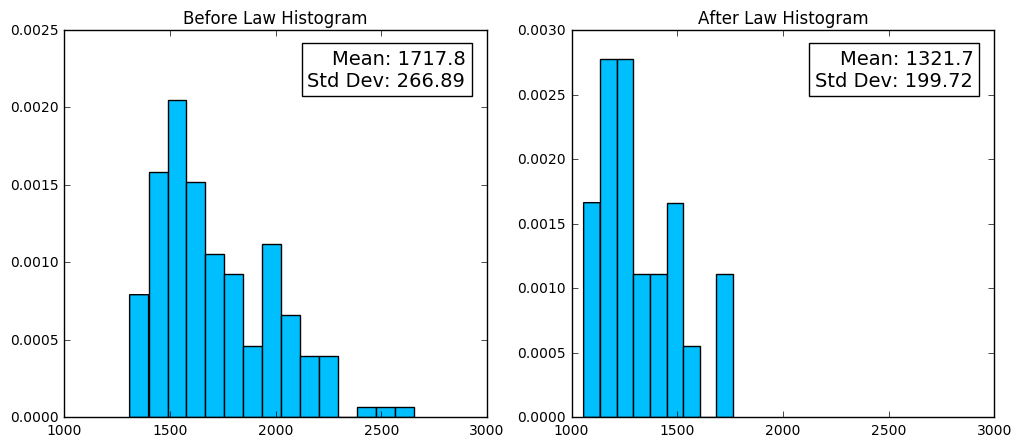

In [152]:
plt.figure(1, figsize=[12,5])

def addBox(mean, std):
    """ Adds text box to plot with mean and standard deviation"""
    txtProps = dict(boxstyle='square', facecolor='white', alpha=1)
    textstr = "    Mean: {}\nStd Dev: {}".format(round(mean,1), round(std, 2))
    p.text(0.575, 0.95, textstr, transform=p.transAxes, fontsize=14,
            verticalalignment='top', bbox=txtProps)

# Plotting Pre-Law Data
p = plt.subplot(1,2,1)
plt.hist(pre_law, bins=15, normed=True, color="deepskyblue")
plt.title("Before Law Histogram")
plt.xlim([1000, 3000])
addBox(pre_law.mean(), pre_law.std())


# Plotting Post-Law Data
p = plt.subplot(1,2,2)
plt.hist(post_law, bins=9, normed=True, color="deepskyblue")
plt.title("After Law Histogram")
plt.xlim([1000, 3000])
addBox(post_law.mean(), post_law.std())

plt.show()

The data doesn't look normal and it looks a bit skewed, so let's use Levene's test using the median instead of the mean. 

In [153]:
pval = ss.levene(pre_law, post_law, center="median")[1]
print("p-values for Levene's test:  %0.2f" % pval)

p-values for Levene's test:  0.14


So we can assume that the varances are equal. If we run a $t$-test, we get the following $p$-value:

In [154]:
pval = ss.ttest_ind(pre_law, post_law, axis=0, equal_var=True)[1]
print("p-values for t-test:  %0.2e" % pval)
print("Avg. casualties before law:  %0.2f" % pre_law.mean())
print("Avg. casualties after law:  %0.2f" % post_law.mean())

print("We saw %0.2d few deaths per month on average after the seatbelt law." \
      % round(-(post_law.mean()-pre_law.mean())))

p-values for t-test:  9.76e-11
Avg. casualties before law:  1717.75
Avg. casualties after law:  1321.70
We saw 396 few deaths per month on average after the seatbelt law.


So this says that we can reject the null hypothesis and conclude that the pre-law and post-law means are different. But this can still be ify because of the seasonal fluctuations. 


## Time Series Approach
The t-test should be give decent result since we have two full cycles of the monthly fluctuations but we can be more accurate by taking those fluctuations into account. We can creat an ARMA model. We need to start by checkign stationarity of the series.

In [155]:
adfuller(pre_law)

(-1.30341684382339,
 0.62760765722723977,
 13,
 155,
 {'1%': -3.4732590518613002,
  '10%': -2.5768120811654525,
  '5%': -2.8803740821053339},
 1997.3637195610636)

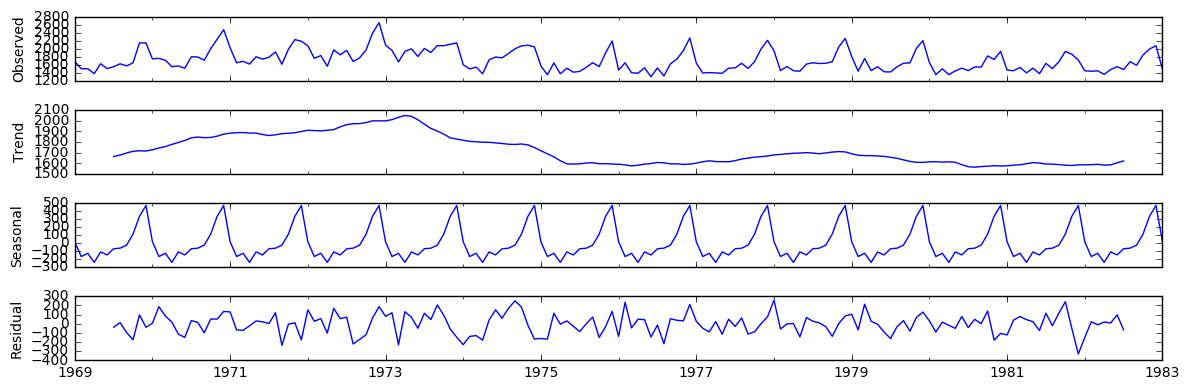

In [156]:
decomp = sm.tsa.seasonal_decompose(pre_law)
decomp.plot()

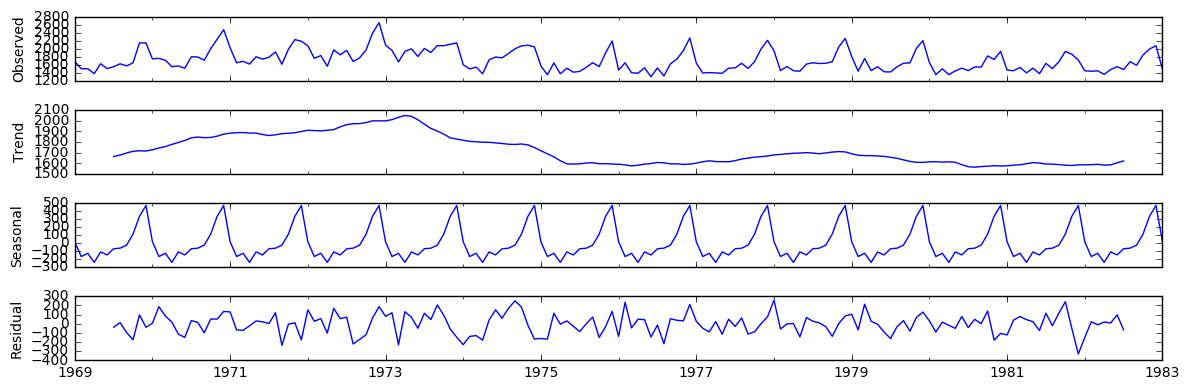

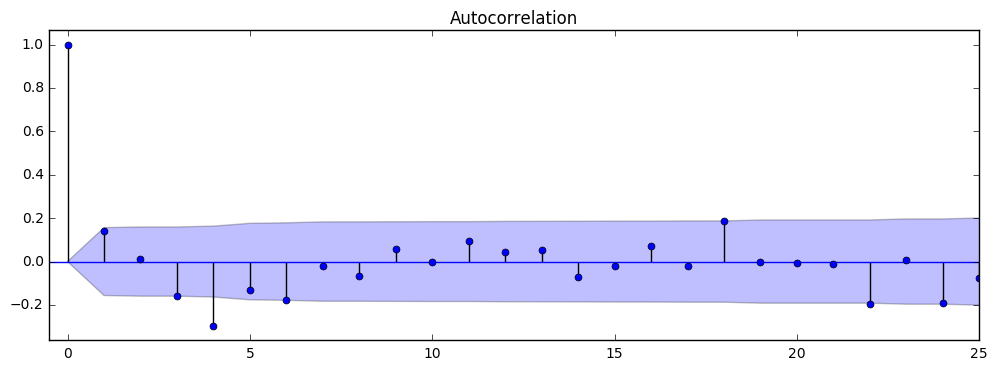

In [157]:
plot_acf(decomp.resid[~decomp.resid.isnull()])
plt.xlim([-.5,25])
plt.show()

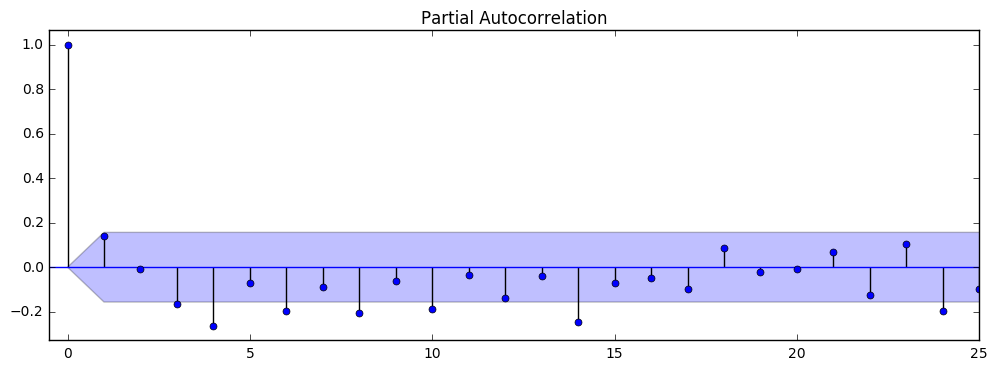

In [158]:
plot_pacf(decomp.resid[~decomp.resid.isnull()])
plt.xlim([-.5,25])
plt.show()

To choose how many lags to include in the model for the autoregression, we can plot the autocorrelation plot. The autocorrelation plot below has the first peak above the confidence region (light blue) for two time steps, so we could use two lags for the autoregression part. 

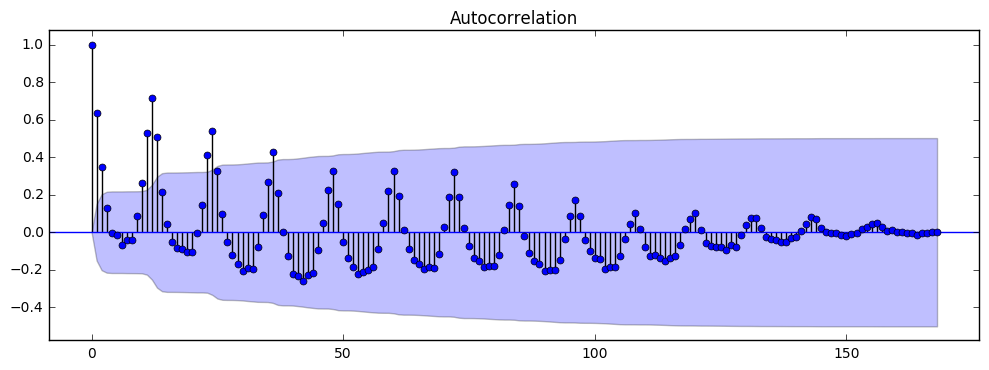

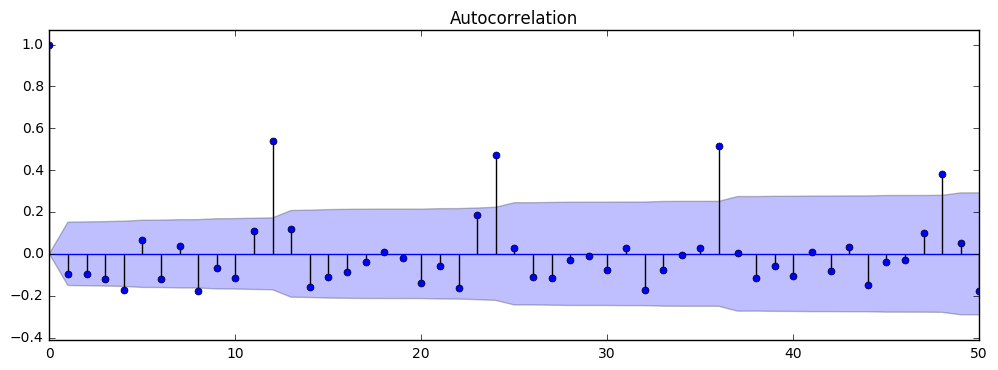

In [159]:
plt.rcParams['figure.figsize'] = 12,4
plot_acf(pre_law)
plot_acf(pre_law.diff(1)[1:])
plt.xlim([0,50])
plt.show()

We can do a similar thing to find how large to set the moving average window using the partial autocorrelation plot. The partial Autocorrelation below shows only 1 spike, so the moving average window will only be 1 time step wide. 

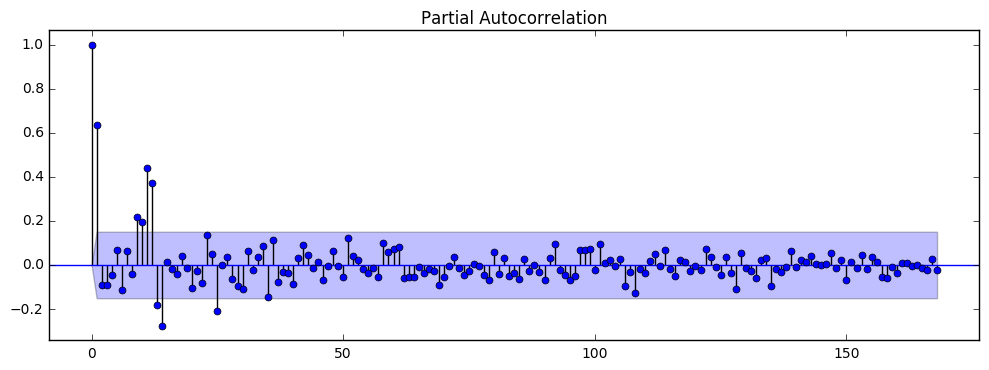

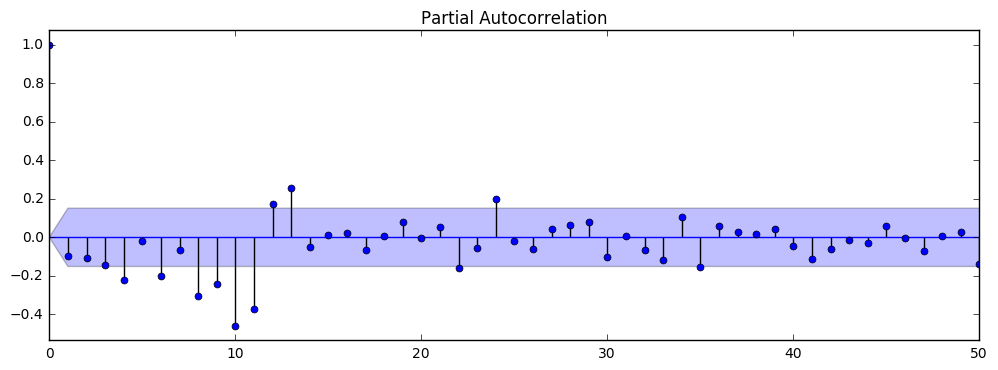

In [160]:
plot_pacf(pre_law)
plot_pacf(pre_law.diff(1)[1:])
plt.xlim([0,50])
plt.show()

Another thing to note is the periodicity in the time series that has a period of 12 (we can confirm this from the second peak happeneing at 12 lags). To account for this, we will add indicator variable for each month as exogenous features. 

In [161]:
months = pd.get_dummies(casualtyData.index.month)
months.index = casualtyData.index
casualtyData = casualtyData.join(months)

casualtyData.sample(5)

,casualties,lawEnacted,1,2,3,4,5,6,7,8,9,10,11,12
1970-06-01,1520.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1973-04-01,1941.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1977-10-01,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1974-03-01,1548.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01,1752.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now I'll train the model on the data before the law was enacted. Thn I'll use this to forcast what the carualty numbers would have been if the law was never enacted. I'll then use that forcast to compare to the actual post-law data.

In [162]:
pre_law = casualtyData[casualtyData.index<law_start]
post_law = casualtyData[casualtyData.index>=law_start]

In [163]:
ARIMA = sm.tsa.ARIMA

model = ARIMA(endog=pre_law.casualties, 
              order=(1,1,1), 
              exog=pre_law[np.arange(1,13)]).fit()

In [164]:
nSteps = 24
forcast = model.forecast(steps=nSteps-1, exog=post_law[np.arange(1,13)])

forcastDF = pd.DataFrame({"casualties":forcast[0], 
                          "CI_low":forcast[2][:,0], 
                          "CI_hi":forcast[2][:,1]}, index=post_law.index[0:nSteps])

In [165]:
forcast = pd.DataFrame([],index=pd.to_datetime(map(lambda x: "1985-%02d-01" % x, np.arange(1,13))))
months = pd.get_dummies(forcast.index.month)
months.index = forcast.index
forcastIdx = forcast.join(months)

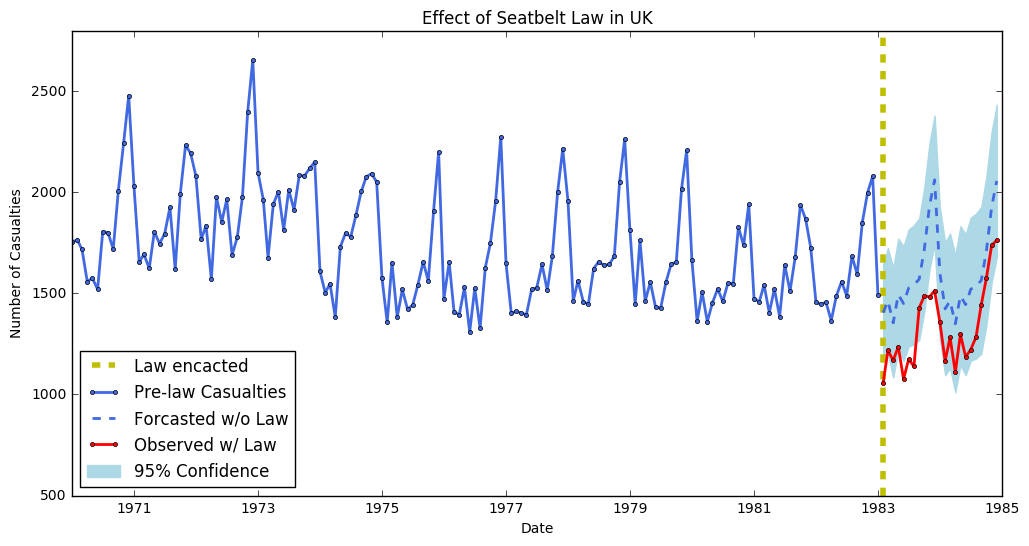

In [166]:
plt.figure(2, figsize=[12,6])
plt.axvline(law_start, c="y", ls="--", lw=4, label="Law encacted")
plt.plot(pre_law.casualties, 
         "royalblue", lw=2, 
          marker="o", ms=3, 
         label="Pre-law Casualties")
plt.plot(forcastDF.casualties, "royalblue", ls="--", lw=2, 
         label="Forcasted w/o Law")
plt.fill_between(forcastDF.index.values,
                 forcastDF["CI_low"],
                 forcastDF["CI_hi"], 
                 color="lightblue", 
                 label="95% Confidence")
plt.plot(post_law.casualties, "ro-", ms=3, lw=2, label="Observed w/ Law")
plt.ylim([500, 2800])
plt.xlim(["1970","1985"])
plt.title("Effect of Seatbelt Law in UK")
plt.xlabel("Date")
plt.ylabel("Number of Casualties")
plt.legend(loc="lower left")
plt.show()

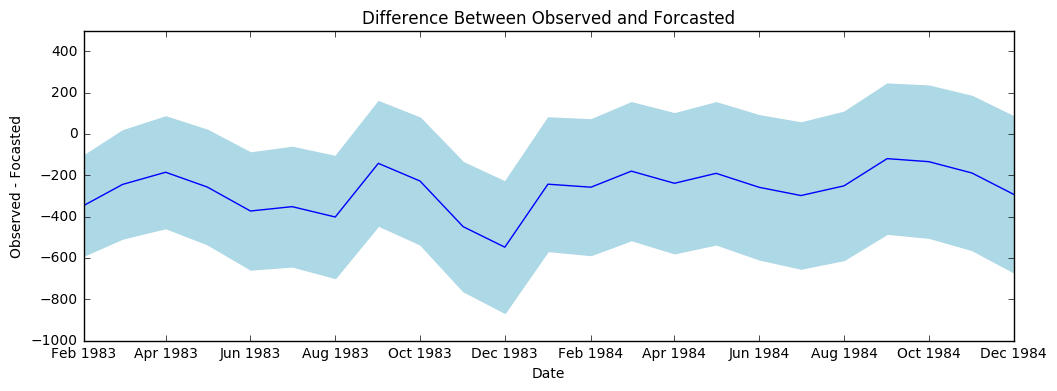

Average of 269 fewer casualties.


In [167]:
plt.figure(3, figsize=[12,4])

diff = post_law.casualties - forcastDF.casualties
diff_CIlo = post_law.casualties - forcastDF.CI_low
diff_CIhi = post_law.casualties - forcastDF.CI_hi
plt.fill_between(forcastDF.index.values,
                 diff_CIlo,
                 diff_CIhi, 
                 color="lightblue", 
                 label="95% Confidence")
plt.plot(diff)
plt.title("Difference Between Observed and Forcasted")
plt.xlabel("Date")
plt.ylabel("Observed - Focasted")
plt.ylim([-1000,500])
plt.show()

print("Average of %d fewer casualties." % round(-diff.mean()))

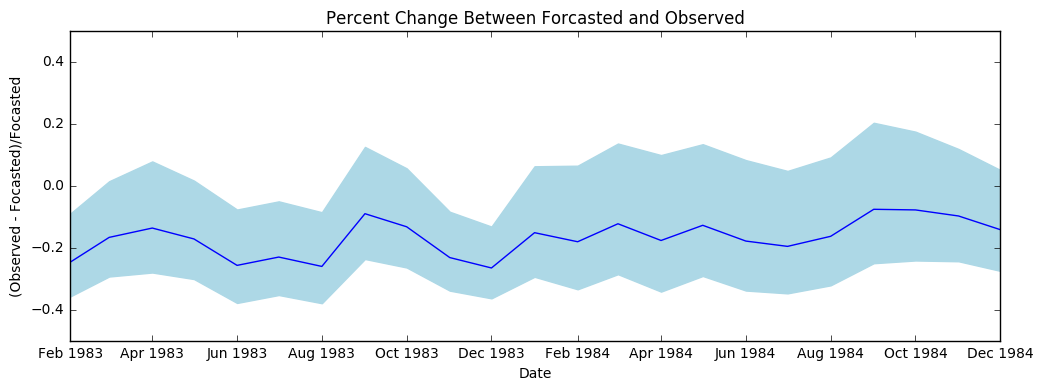

Average of 16.94% decrease in casualties.


In [168]:
plt.figure(3, figsize=[12,4])

change = (post_law.casualties - forcastDF.casualties) / forcastDF.casualties
change_CIlo = (post_law.casualties - forcastDF.CI_low) / forcastDF.CI_low
change_CIhi = (post_law.casualties - forcastDF.CI_hi) / forcastDF.CI_hi
plt.fill_between(forcastDF.index.values,
                 change_CIlo,
                 change_CIhi, 
                 color="lightblue", 
                 label="95% Confidence")
plt.plot(change)
plt.title("Percent Change Between Forcasted and Observed")
plt.xlabel("Date")
plt.ylabel("(Observed - Focasted)/Focasted")
plt.ylim([-.5,.5])
plt.show()

print("Average of %0.2f%% decrease in casualties." % (-change.mean()*100))